<a href="https://colab.research.google.com/github/Homabeyrami/ML_Project_Pra/blob/main/KC_4_V5H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle API and Data Download




# Install



In [15]:
!pip install optuna
!pip install shap
!pip install yellowbrick
!pip install xgboost

<a id = "1"></a><br>
# Downloading and extracting data


In [16]:
# Run this cell to download and extract data
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e7:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73291%2F8930475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240709%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240709T060028Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2624b1110f8bfc94752342c2ce07fdc5719dd07abd9a4c95934ae25a92674de4ddd2ef2ef90c707a5facab1fbf765df450adcd6e00eedc0de31b2b51dbb841f2a9b300875653097440868f21db1d1c55e8cd28564fc7e8a774efc9a6e4c6e530856d23a0d3e979c8e2fcf7fab1e3aa75c43db4a89beb5d9f05ea5bd59489804471c25b071f4bc15a923e16712626103075899c35902c0430844bb06ff702ad430da1c8946f4da04bf016b49c213dff0e842fbb1dae9c977dcaf999d616d38ecafbe36832f080d7a6bdb053c56b13f3ddb99fb9fdcad2eba54baaf2edfa032264a2b75a7eb03251418a2aef0bdf9bcdd7c0edff6f006ce488ffdfa626f99f3e26'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 259402906 bytes downloaded
Downloaded and uncompressed: playground-series-s4e7
Data source import complete.


# Load Python Pakages

In [17]:
#basics
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno


import warnings
warnings.filterwarnings("ignore")
import os
#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from xgboost import XGBClassifier
import xgboost as xgb
# Import necessary libraries
import shap
from xgboost import plot_importance


#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

random_state = 42
print("Libraries imported successfully.")



Libraries imported successfully.


<a id = "2"></a><br>
#  First look to data

In [18]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

# Display first few rows of the datasets
print(train_df.head())
print(test_df.head())


   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female   35                1          1.0                   0   
4   4  Female   36                1         15.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   
2    < 1 Year             No         38043.0                 152.0      254   
3    1-2 Year            Yes          2630.0                 156.0       76   
4    1-2 Year             No         31951.0                 152.0      294   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  
        

In [19]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [34]:
print(train_df.shape)
print(test_df.shape)

(11504798, 12)
(7669866, 11)


In [22]:
'''# Checking for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

SyntaxError: invalid syntax (<ipython-input-22-7486b99222ba>, line 1)

<a id = "3"></a><br>
## Descpriptive statistics

In [23]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


#Distribution of target variable

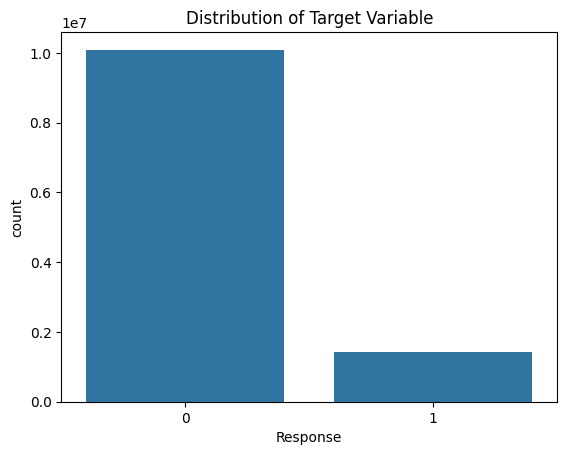

In [24]:

sns.countplot(x='Response', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()


#Examining the distribution of numerical features

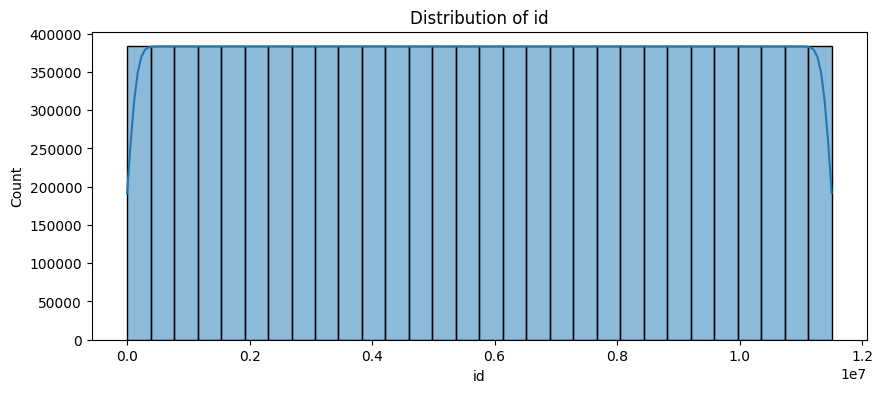

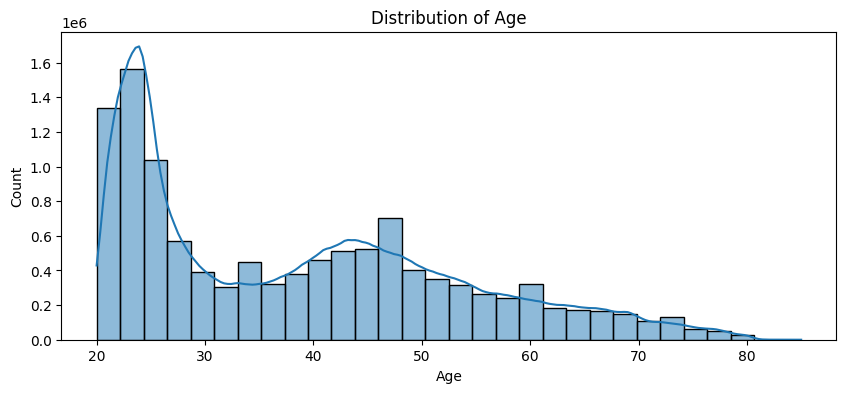

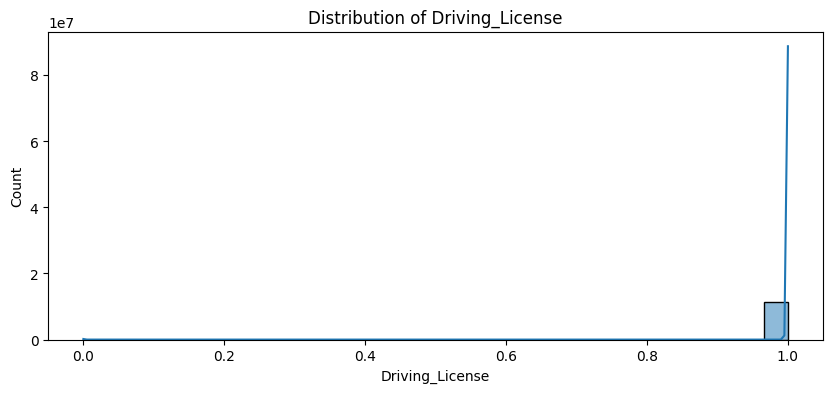

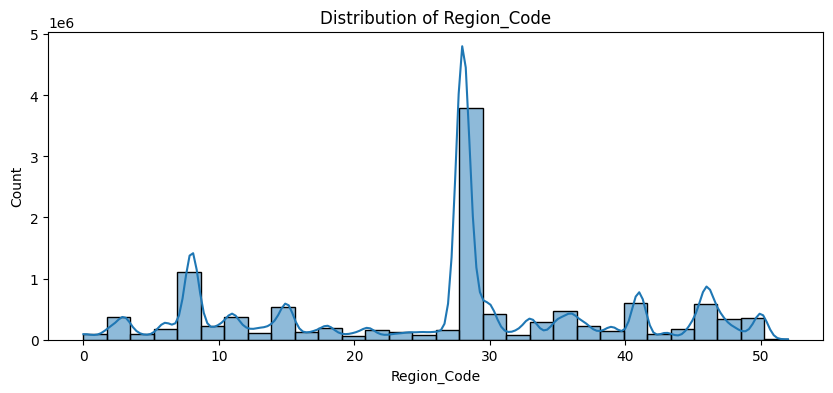

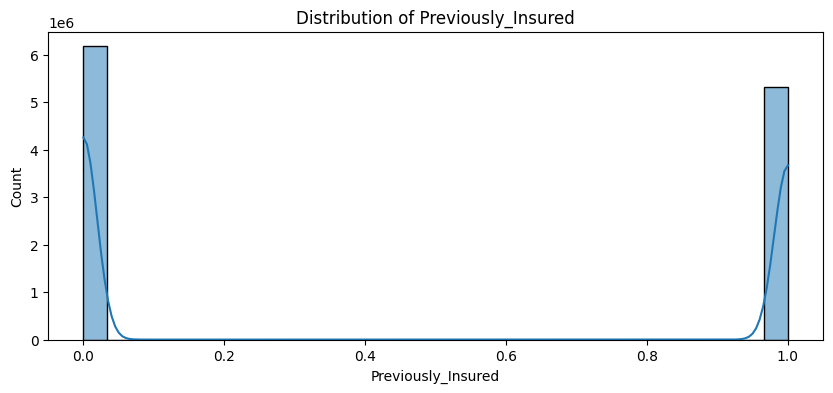

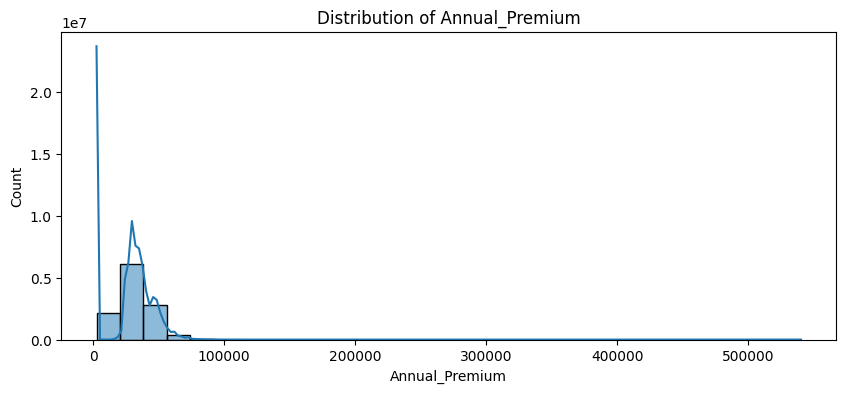

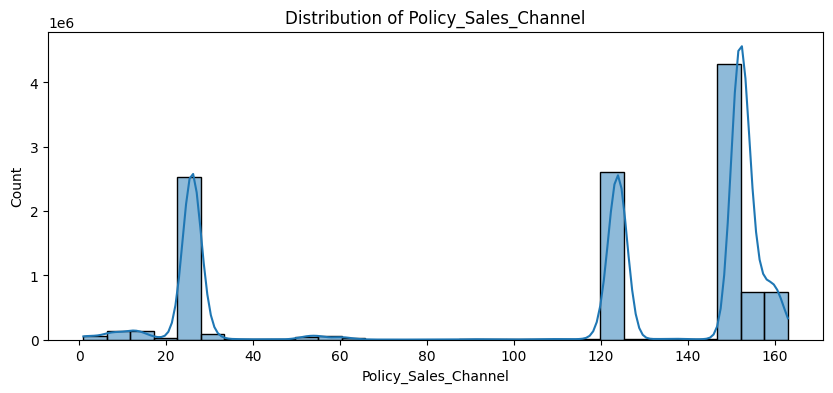

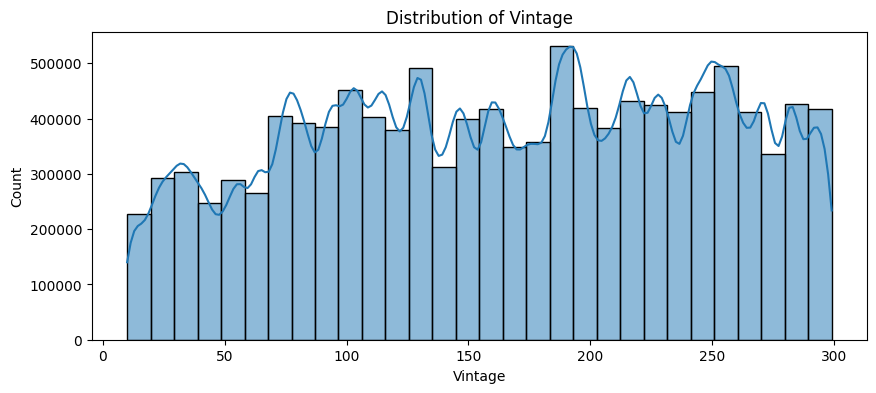

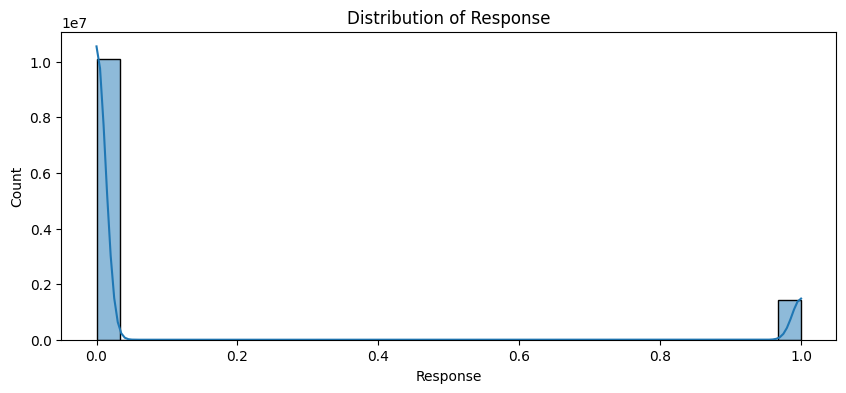

In [25]:

numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns

for feature in numeric_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(train_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


# Examining the correlation of features

# Examining the distribution of categorical features

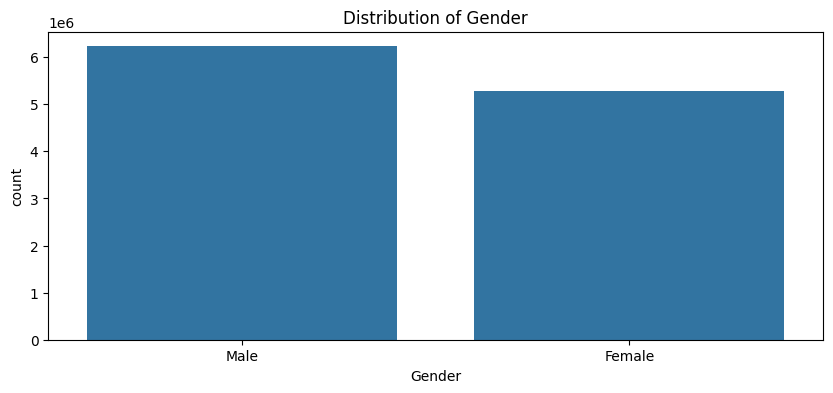

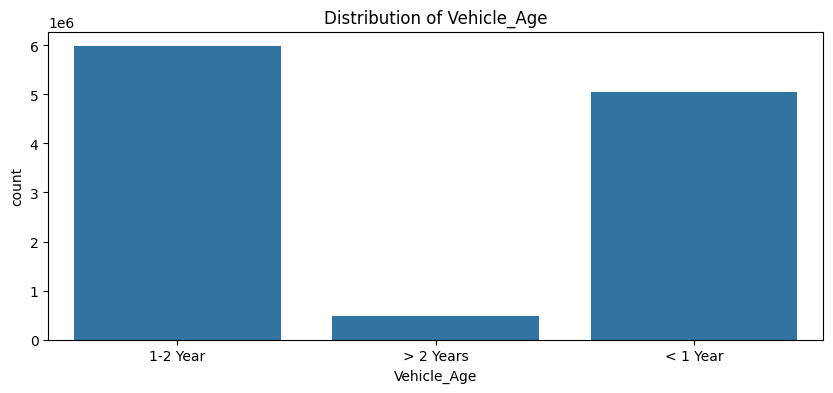

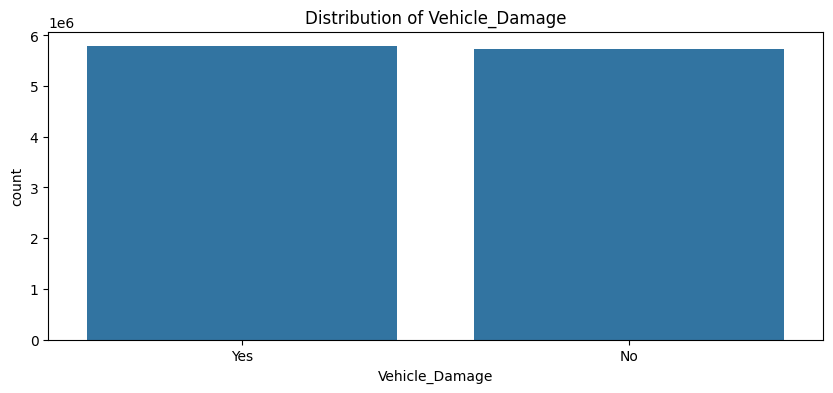

In [31]:

categorical_features = train_df.select_dtypes(include=['object']).columns

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=train_df)
    plt.title(f'Distribution of {feature}')
    plt.show()


## Grouping features for preprocessing purposes

In [ ]:
train_df.nunique().sort_values()

Gender                         2
Driving_License                2
Previously_Insured             2
Vehicle_Damage                 2
Response                       2
Vehicle_Age                    3
Region_Code                   54
Age                           66
Policy_Sales_Channel         152
Vintage                      290
Annual_Premium             51728
id                      11504798
dtype: int64

In [ ]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype
---  ------                -----
 0   id                    int64
 1   Gender                object
 2   Age                   int64
 3   Driving_License       int64
 4   Region_Code           float64
 5   Previously_Insured    int64
 6   Vehicle_Age           object
 7   Vehicle_Damage        object
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64
 11  Response              int64
dtypes: float64(3), int64(6), object(3)
memory usage: 1.1+ GB


In [ ]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Response"]

target = "Response"

binary_features = ['Previously_Insured','Driving_License']

categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']


train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

continuous_features = list(set(feature_list) - set(binary_features)- set(categorical_features))

assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numerical
label_encoders = {}
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

for feature in categorical_features:
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    label_encoders[feature] = le

# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if feature != "Response"]
target = "Response"

binary_features = ['Previously_Insured', 'Driving_License']
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

continuous_features = list(set(feature_list) - set(binary_features) - set(categorical_features))

assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()



<a id = "5"></a><br>
# Feature Engineering

In [38]:

print(train_df.columns)
# For example
if 'feature1' in train_df.columns and 'feature2' in train_df.columns:
    train_df['new_feature'] = train_df['feature1'] / train_df['feature2']
    test_df['new_feature'] = test_df['feature1'] / test_df['feature2']

# Converting categorical features to numerical features
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
# Aligning train and test columns
train_df, test_df = train_df.align(test_df, join='left', axis=1)
test_df = test_df.fillna(0)  # پر کردن مقادیر مفقودی در test_df


Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response',
       'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')


<a id = "7"></a><br>
# Modeling and hyperparameter tuning

In [45]:
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# تعریف متغیر y و حذف ستون Response از train_df
# Define target variable y and drop Response column from train_df
y = train_df['Response']
train_df = train_df.drop(columns=['Response'])

# استفاده از یک زیرمجموعه کوچکتر از داده‌ها برای آزمایش اولیه
# Using a smaller subset of data for initial testing
sample_frac = 0.05
train_df_sampled = train_df.sample(frac=sample_frac, random_state=42)
y_sampled = y.loc[train_df_sampled.index]

# تنظیم Cross-Validation
# Setting up Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    xgb_param = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 1000, 10000),
        'eta': trial.suggest_float('xgb_eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 18),
        'subsample': trial.suggest_float('xgb_subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.1, 1.0),
        'alpha': trial.suggest_float('xgb_alpha', 1e-8, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 1.0),
        'eval_metric': 'auc',
        'random_state': 42,
        'max_bin': 262143,
        'enable_categorical': True,
        'early_stopping_rounds': 10
    }

    xgb_model = XGBClassifier(**xgb_param)

    lgbm_param = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 1000, 10000),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('lgbm_max_depth', 3, 18),
        'subsample': trial.suggest_float('lgbm_subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('lgbm_colsample_bytree', 0.1, 1.0),
        'random_state': 42
    }

    lgbm_model = LGBMClassifier(**lgbm_param)

    catboost_param = {
        'iterations': trial.suggest_int('catboost_iterations', 1000, 10000),
        'learning_rate': trial.suggest_float('catboost_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('catboost_depth', 3, 18),
        'random_state': 42
    }

    catboost_model = CatBoostClassifier(**catboost_param, verbose=0)

    stacking_model = StackingClassifier(estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ], final_estimator=LogisticRegression(), cv=kf)

    auc_scores = []

    for train_index, val_index in kf.split(train_df_sampled):
        X_train, X_val = train_df_sampled.iloc[train_index], train_df_sampled.iloc[val_index]
        y_train, y_val = y_sampled.iloc[train_index], y_sampled.iloc[val_index]

        stacking_model.fit(X_train, y_train)
        y_pred_prob = stacking_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_prob)
        auc_scores.append(auc)

    return sum(auc_scores) / len(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


KeyError: "['Response'] not found in axis"

In [ ]:
# بهترین پارامترها
# Best hyperparameters
best_params = {
    'xgb_n_estimators': trial.params['xgb_n_estimators'],
    'xgb_eta': trial.params['xgb_eta'],
    'xgb_max_depth': trial.params['xgb_max_depth'],
    'xgb_subsample': trial.params['xgb_subsample'],
    'xgb_colsample_bytree': trial.params['xgb_colsample_bytree'],
    'xgb_alpha': trial.params['xgb_alpha'],
    'xgb_gamma': trial.params['xgb_gamma'],
    'lgbm_n_estimators': trial.params['lgbm_n_estimators'],
    'lgbm_learning_rate': trial.params['lgbm_learning_rate'],
    'lgbm_max_depth': trial.params['lgbm_max_depth'],
    'lgbm_subsample': trial.params['lgbm_subsample'],
    'lgbm_colsample_bytree': trial.params['lgbm_colsample_bytree'],
    'catboost_iterations': trial.params['catboost_iterations'],
    'catboost_learning_rate': trial.params['catboost_learning_rate'],
    'catboost_depth': trial.params['catboost_depth']
}

# آموزش مدل نهایی با بهترین پارامترها
# Train final model with best parameters
xgb_model = XGBClassifier(
    n_estimators=best_params['xgb_n_estimators'],
    eta=best_params['xgb_eta'],
    max_depth=best_params['xgb_max_depth'],
    subsample=best_params['xgb_subsample'],
    colsample_bytree=best_params['xgb_colsample_bytree'],
    alpha=best_params['xgb_alpha'],
    gamma=best_params['xgb_gamma'],
    eval_metric='auc',
    random_state=42,
    max_bin=262143,
    enable_categorical=True,
    early_stopping_rounds=50
)

lgbm_model = LGBMClassifier(
    n_estimators=best_params['lgbm_n_estimators'],
    learning_rate=best_params['lgbm_learning_rate'],
    max_depth=best_params['lgbm_max_depth'],
    subsample=best_params['lgbm_subsample'],
    colsample_bytree=best_params['lgbm_colsample_bytree'],
    random_state=42
)

catboost_model = CatBoostClassifier(
    iterations=best_params['catboost_iterations'],
    learning_rate=best_params['catboost_learning_rate'],
    depth=best_params['catboost_depth'],
    random_state=42,
    verbose=1000
)

# ترکیب مدل‌ها با Stacking
# Combine models with Stacking
stacking_model = StackingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], final_estimator=LogisticRegression(), cv=kf)

# آموزش مدل نهایی
# Train the final model
stacking_model.fit(train_df, y)

# پیش‌بینی روی داده‌های تست
# Predict on test data
y_test_pred_prob = stacking_model.predict_proba(test_df)[:, 1]

# ایجاد فایل سابمیت
# Create submission file
submission = pd.DataFrame({'id': test_df['id'], 'Response': y_test_pred_prob})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")


<a id = "7"></a><br>
#Explainable ML & Feature importances



In [ ]:
import shap

# محاسبه اهمیت ویژگی‌ها با استفاده از SHAP
# Calculate feature importance using SHAP
explainer = shap.TreeExplainer(stacking_model.named_estimators_['xgb'])
shap_values = explainer.shap_values(train_df)

# نمودار اهمیت ویژگی‌ها
# Summary plot of feature importance
shap.summary_plot(shap_values, train_df, plot_type="bar")

# نمودار SHAP برای نمونه‌های منفرد
# SHAP force plot for individual samples
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train_df.iloc[0,:])


<a id = "14"></a><br>
# Submission

In [ ]:
# Create submission file
submission = pd.DataFrame({'id': test_df['id'], 'Response': y_test_pred_prob})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")


In [ ]:
'''test_df_d = xgb.DMatrix(test_df, enable_categorical=True)

In [ ]:
'''sub_preds = booster.predict(test_df_d,iteration_range=(0, model.best_iteration + 1))

In [ ]:
'''output = pd.DataFrame({'id': test_df.index,
                       'Response': sub_preds})

output.head()


In [ ]:
'''output.to_parquet('submission.parquet', index=False)
